**Why GPUs?**

  * GPUs = "graphics processing units"
  * Vector transformations:
     * Given a vector **V** = <X, Y, Z>, e.g., <1.0, 0.0, 0.0>
     * To transform the vector, all transformations multiply the vector by a matrix
     * e.g., to rotate V *r* radians around the Y-axis, multiply V by:
     
|          |   |         |
|----------|---|---------|
| cos *r*  | 0 | sin *r* | 
| 0        | 1 | 0       |
| -sin *r* | 0 | cos *r* |


In [5]:
import numpy as np

V = np.array([1,0,0])
r = np.pi
transform = np.array([[np.cos(r),0,np.sin(r)],
                     [0,1,0],
                     [-np.sin(r),0,np.cos(r)]])

print("%s rotated around Y-axis by %s radians (%s degrees) = %s" % (V,r,np.rad2deg(r),V @ transform))
print("%s @ %s = %s" % (V,transform,V @ transform))

[1 0 0] rotated around Y-axis by 3.141592653589793 radians (180.0 degrees) = [-1.0000000e+00  0.0000000e+00  1.2246468e-16]
[1 0 0] @ [[-1.0000000e+00  0.0000000e+00  1.2246468e-16]
 [ 0.0000000e+00  1.0000000e+00  0.0000000e+00]
 [-1.2246468e-16  0.0000000e+00 -1.0000000e+00]] = [-1.0000000e+00  0.0000000e+00  1.2246468e-16]


**Historical accident**

  * GPU chips are optimized for exactly this type of matrix multiplication
  * If you can transform a 3D vector, you can transform a 300D vector

In [6]:
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ImportError: numpy.core.multiarray failed to import

In [ ]:
import torch
import time

In [ ]:
torch.cuda.is_available()

In [7]:
ntimes = 1

results = []
for n in range(2000, 10000, 1000):

    print(f'\n------------ n is {n}')
    
    # compare to operations at the end of notebook 01
    a = np.random.uniform(size=(n, n)).astype(np.float32)
    b = np.random.uniform(size=(n, n)).astype(np.float32)
    print('np type', a.dtype)

    at = torch.from_numpy(a)
    bt = torch.from_numpy(b)
    print('torch type', at.dtype)

    atgpu = at.to('cuda')
    btgpu = bt.to('cuda')
    print('cuda type', atgpu.dtype)
    
    
    # @ = matrix multiplcation "matmul" operator
    # AB = C -> c_ij = sum(a_ik*b_kj) for k in [1..n], i in [1..# rows in A], j in [1..# cols in B]
    # (n is the magnitude of the other dimension in each matric)
    # therefore AB is defined iff number of columns in A == number of rows in B
    
    start_time = time.time()
    for i in range(ntimes):
        c = a @ b
    nptime = time.time() - start_time
    print(f'Numpy took {nptime:.5f} seconds. {c[0, 0:5]}')

    
    start_time = time.time()
    for i in range(ntimes):
        ct = at @ bt
    torchtime = time.time() - start_time
    print(f'Pytorch took {torchtime:.5f} seconds. {ct[0, 0:5]}')
    
    
    start_time = time.time()
    for i in range(ntimes):
        ctgpu = atgpu @ btgpu
    torch.cuda.synchronize()
    cudatime = time.time() - start_time
    print(f'Pytorch cuda took {cudatime:.5f} seconds. {ctgpu[0, 0:5]}')
    print(f'Cuda is {nptime / cudatime :.5f} times faster.')

    results.append([n, nptime, torchtime, cudatime])




------------ n is 2000
np type float32
torch type torch.float32
cuda type torch.float32
Numpy took 0.06582 seconds. [484.77515 496.69208 490.30414 498.35284 491.30005]
Pytorch took 0.06981 seconds. tensor([484.7751, 496.6921, 490.3041, 498.3528, 491.3000])
Pytorch cuda took 0.00602 seconds. tensor([484.7747, 496.6921, 490.3037, 498.3528, 491.3000], device='cuda:0')
Cuda is 10.93579 times faster.

------------ n is 3000
np type float32
torch type torch.float32
cuda type torch.float32
Numpy took 0.14062 seconds. [771.99384 747.58167 752.7151  731.07446 747.0325 ]
Pytorch took 0.15758 seconds. tensor([771.9938, 747.5817, 752.7151, 731.0745, 747.0325])
Pytorch cuda took 0.01695 seconds. tensor([771.9950, 747.5811, 752.7155, 731.0739, 747.0323], device='cuda:0')
Cuda is 8.29421 times faster.

------------ n is 4000
np type float32
torch type torch.float32
cuda type torch.float32
Numpy took 0.36203 seconds. [ 980.05304  984.1255   989.20294 1010.5798  1003.4144 ]
Pytorch took 0.36103 second

In [12]:
results[:, -1] # results is currently a list, can't do this operation on lists

TypeError: list indices must be integers or slices, not tuple

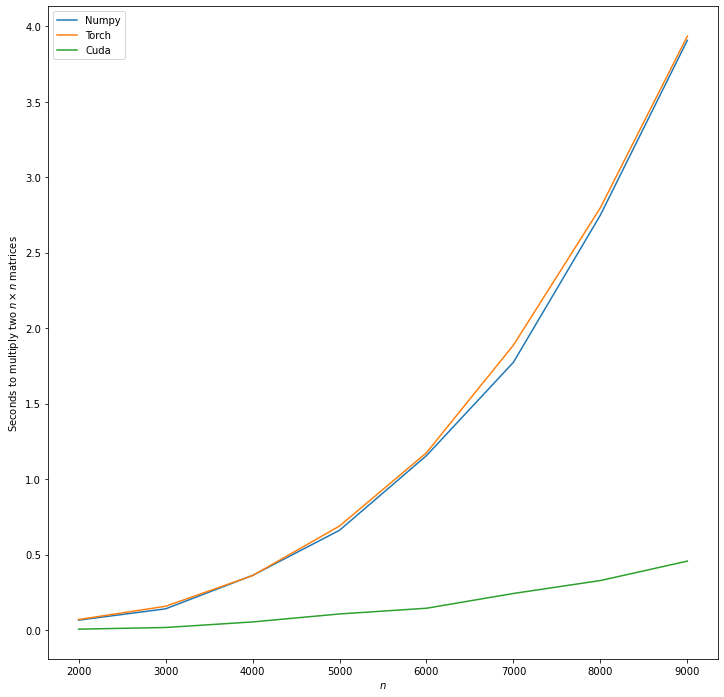

In [13]:
results = np.array(results)

plt.figure(figsize=(12, 12))
plt.plot(results[:, 0], results[:, 1:])
plt.legend(('Numpy', 'Torch', 'Cuda'))
plt.xlabel('$n$')
plt.ylabel(r'Seconds to multiply two $n \times n$ matrices');

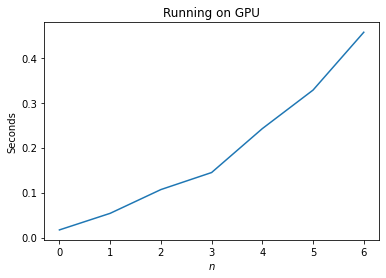

In [14]:
plt.plot(results[1:, -1])
plt.xlabel('$n$')
plt.ylabel('Seconds')
plt.title('Running on GPU');